In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
file_path = "train.csv"
df = pd.read_csv(file_path, nrows=10000*100000)
df["dt"] = df["time_to_failure"].shift() - df["time_to_failure"]
df["time"] = df["dt"].cumsum()
df.dropna(inplace=True)

In [70]:
df.head()

,acoustic_data,time_to_failure,dt,time
1,6,1.4691,1.100000e-09,1.100000e-09
2,8,1.4691,1.100000e-09,2.200000e-09
3,5,1.4691,1.100000e-09,3.300000e-09
4,8,1.4691,1.100000e-09,4.400000e-09
5,8,1.4691,1.100000e-09,5.500000e-09


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pandas as pd
import os
import random
import uuid

# Extraire les données
acoustic_data = df["acoustic_data"].values
time_to_failure = df["time_to_failure"].values  # Assumant que 'time_to_failure' est dans le DataFrame

# Calculer le min et max globaux
global_min = np.log10(np.min(acoustic_data[acoustic_data > 0]) + 1e-10)
global_max = np.log10(np.max(acoustic_data) + 1e-10)

# Paramètres du spectrogramme
nperseg = 256
noverlap = 128
nfft = 512
scaling = 'density'
mode = 'magnitude'
cmap = 'viridis'
fmin = 0
fmax = 100000000

# Nombre de lignes par segment et nombre d'images à générer
segment_length = 10000
num_images = 1000  # Spécifiez le nombre d'images à générer

# Dossier de sauvegarde des images
output_folder = 'spectrogram_images'
os.makedirs(output_folder, exist_ok=True)

# Liste pour stocker les métadonnées
metadata = []

def generate_spectrogram(data, fs, save_path=None):
    frequencies, times, Sxx = spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling=scaling, mode=mode)
    
    if fmin is not None:
        valid_idx = frequencies >= fmin
        Sxx = Sxx[valid_idx, :]
        frequencies = frequencies[valid_idx]
    if fmax is not None:
        valid_idx = frequencies <= fmax
        Sxx = Sxx[valid_idx, :]
        frequencies = frequencies[valid_idx]
    
    if frequencies.size == 0 or Sxx.size == 0:
        raise ValueError("Les filtres de fréquences ont éliminé toutes les données. Ajustez fmin et fmax.")

    # Normalisation des valeurs de Sxx
    Sxx = np.log10(Sxx + 1e-10)
    Sxx = (Sxx - global_min) / (global_max - global_min)

    # Tracer le spectrogramme sans les axes et les annotations
    fig, ax = plt.subplots(figsize=(1.28, 0.64))  # Taille de l'image en pouces (128x64 pixels à 100 dpi)
    ax.axis('off')  # Désactiver les axes
    ax.set_position([0, 0, 1, 1])  # Utiliser tout l'espace disponible
    ax.pcolormesh(times, frequencies, Sxx, shading='gouraud', cmap=cmap)
    
    # Sauvegarder l'image en PNG sans les marges
    if save_path:
        plt.savefig(save_path, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # Fermer la figure pour libérer de la mémoire

# Générer des spectrogrammes et sauvegarder les métadonnées
for _ in range(num_images):
    # Sélection aléatoire d'un point de départ
    start_idx = random.randint(0, len(acoustic_data) - segment_length)
    segment = acoustic_data[start_idx:start_idx + segment_length]
    time_failure_at_end = time_to_failure[start_idx + segment_length - 1]
    
    # ID unique pour le fichier image
    random_id = uuid.uuid4().hex
    image_filename = f"{random_id}.png"
    save_path = os.path.join(output_folder, image_filename)
    fs = 1 / (time[1] - time[0])

    # Générer et sauvegarder le spectrogramme
    try:
        generate_spectrogram_image(segment, fs=fs, save_path=save_path)
        metadata.append((random_id, time_failure_at_end))
    except ValueError:
        # Ignorer les segments qui ne contiennent pas de données après filtrage
        continue

# Sauvegarder les métadonnées dans un fichier CSV
metadata_df = pd.DataFrame(metadata, columns=['randomID', 'time_to_failure'])
csv_file = 'metadata.csv'

# Vérifier si le fichier existe déjà
if os.path.isfile(csv_file):
    # Append au fichier existant sans réécrire l'en-tête
    metadata_df.to_csv(csv_file, mode='a', header=False, index=False)
else:
    # Écrire un nouveau fichier avec l'en-tête
    metadata_df.to_csv(csv_file, index=False)



In [ ]:
plt.plot(df['acoustic_data'])
plt.show()

In [7]:

acoustic_data = df["acoustic_data"]

# Définir les fenêtres
windows = [5, 10, 20, 50, 100, 200, 500]

# Calcul des SMAs (Simple Moving Averages)
for window in windows:
    df[f"SMA_{window}"] = acoustic_data.rolling(window=window).mean()

# Calcul des EMAs (Exponential Moving Averages)
for window in windows:
    df[f"EMA_{window}"] = acoustic_data.ewm(span=window, adjust=False).mean()

# Calcul des écarts-types mobiles
for window in windows:
    df[f"STD_{window}"] = acoustic_data.rolling(window=window).std()

# Calcul des bandes de Bollinger pour une fenêtre de 20 périodes et 2 écarts-types
bollinger_window = 20
bollinger_std = 2

df["Bollinger_Mean"] = acoustic_data.rolling(window=bollinger_window).mean()
df["Bollinger_Upper"] = df["Bollinger_Mean"] + (df["STD_20"] * bollinger_std)
df["Bollinger_Lower"] = df["Bollinger_Mean"] - (df["STD_20"] * bollinger_std)

df.dropna(inplace=True)

array([[ 1.        ,  1.46909943,  4.        , ...,  5.        ,
        10.35084843, -0.35084843],
       [ 0.        ,  1.46909943,  2.4       , ...,  4.8       ,
        10.58928229, -0.98928229],
       [ 6.        ,  1.46909943,  2.6       , ...,  4.75      ,
        10.47620936, -0.97620936],
       ...,
       [ 6.        , 10.41289816,  5.        , ...,  5.8       ,
        10.22956573,  1.37043427],
       [ 4.        , 10.41289816,  5.4       , ...,  5.8       ,
        10.22956573,  1.37043427],
       [ 1.        , 10.41289816,  4.2       , ...,  5.7       ,
        10.47272955,  0.92727045]])

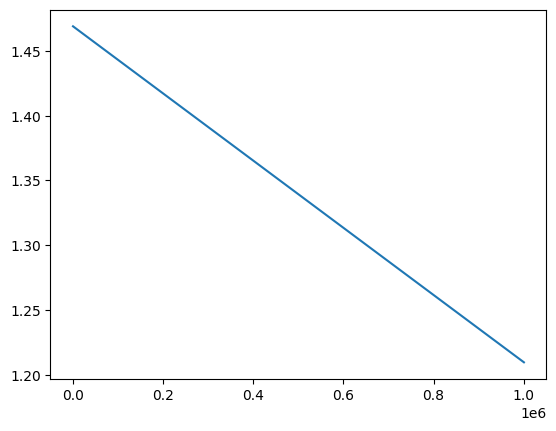

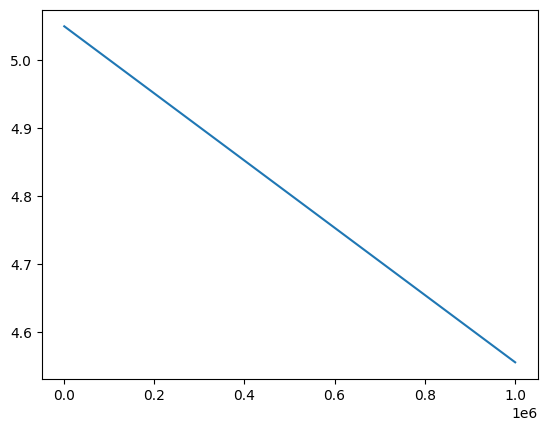

In [3]:
plt.plot(df['time_to_failure'].iloc[[0, 1000000]])
plt.show()

plt.plot(df['SMA_200'].iloc[[0, 1000000]])
plt.show()

In [16]:
df1 = moyenne_acoustic_data(df)

1000it [00:00, 35188.29it/s]

1.4690999832
1.4690999821
1.469099981
1.4690999799
1.4690999788
1.4690999777
1.4690999766
1.4690999755
1.4690999744
1.4690999733
1.4690999722
1.4690999711
1.46909997
1.4690999689
1.4690999678
1.4690999667
1.4690999656
1.4690999645
1.4690999634
1.4690999623
1.4690999612
1.4690999601
1.469099959
1.4690999579
1.4690999568
1.4690999557
1.4690999546
1.4690999535
1.4690999524
1.4690999513
1.4690999502
1.4690999491
1.469099948
1.4690999469
1.4690999458
1.4690999447
1.4690999436
1.4690999425
1.4690999414
1.4690999403
1.4690999392
1.4690999381
1.469099937
1.4690999359
1.4690999348
1.4690999337
1.4690999326
1.4690999315
1.4690999304
1.4690999293
1.4690999282
1.4690999271
1.469099926
1.4690999249
1.4690999238
1.4690999227
1.4690999216
1.4690999205
1.4690999194
1.4690999183
1.4690999172
1.4690999161
1.469099915
1.4690999139
1.4690999128
1.4690999117
1.4690999106
1.4690999095
1.4690999084
1.4690999073
1.4690999062
1.4690999051
1.469099904
1.4690999029
1.4690999018
1.4690999007
1.4690998996
1.469099

In [11]:
df1.head().values

array([[12.        ,  1.46909998],
       [ 6.        ,  1.46909998],
       [ 8.        ,  1.46909998],
       [ 5.        ,  1.46909998],
       [ 8.        ,  1.46909998]])

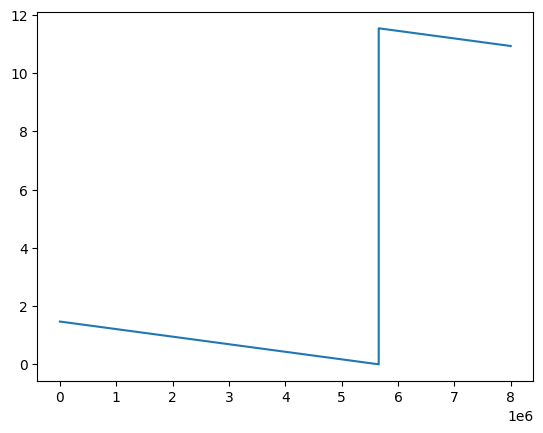

In [4]:
plt.plot(df1['time_to_failure'])
plt.show()

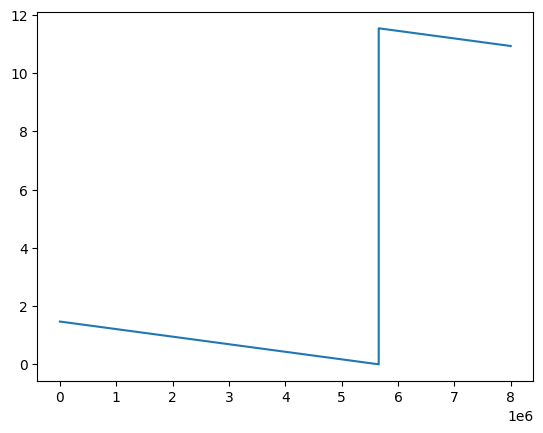

In [5]:
plt.plot(df['time_to_failure'])
plt.show()

In [11]:
stddev = chunk['acoustic_data'].std()
threshold = 12 * stddev

# Create a new column 'is_earthquake' where 1 indicates a potential earthquake and 0 otherwise
chunk['is_earthquake'] = chunk['acoustic_data'].apply(lambda x: 100 if x > threshold else 0)


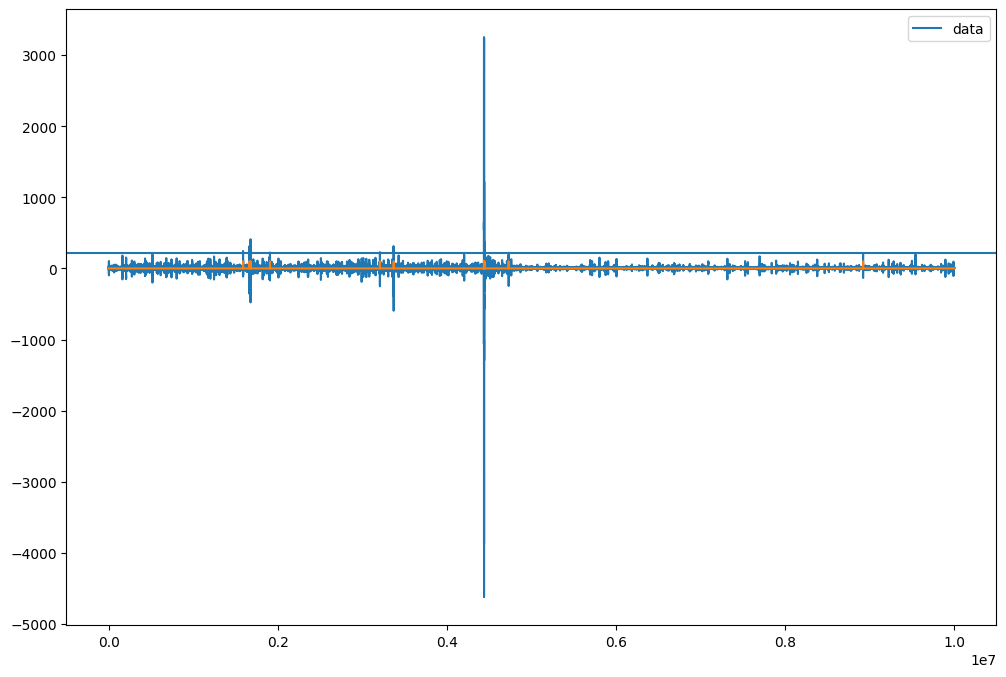

In [12]:
periods = [20, 50, 150, 200]
plt.figure(figsize=(12, 8))
plt.plot(chunk["acoustic_data"], label="data")

plt.axhline(threshold)
plt.plot(chunk['is_earthquake'])
plt.legend()
plt.show()

In [ ]:

periods = [5, 10, 15, 20, 50, 75, 100, 150, 200]

for period in periods:
    chunk[f'MA{period}'] = chunk['acoustic_data'].rolling(window=period).mean()
    chunk[f'MAC{period}'] = chunk[f'MA{period}'].apply(lambda x : 100 if abs(x) > 25 else 0)


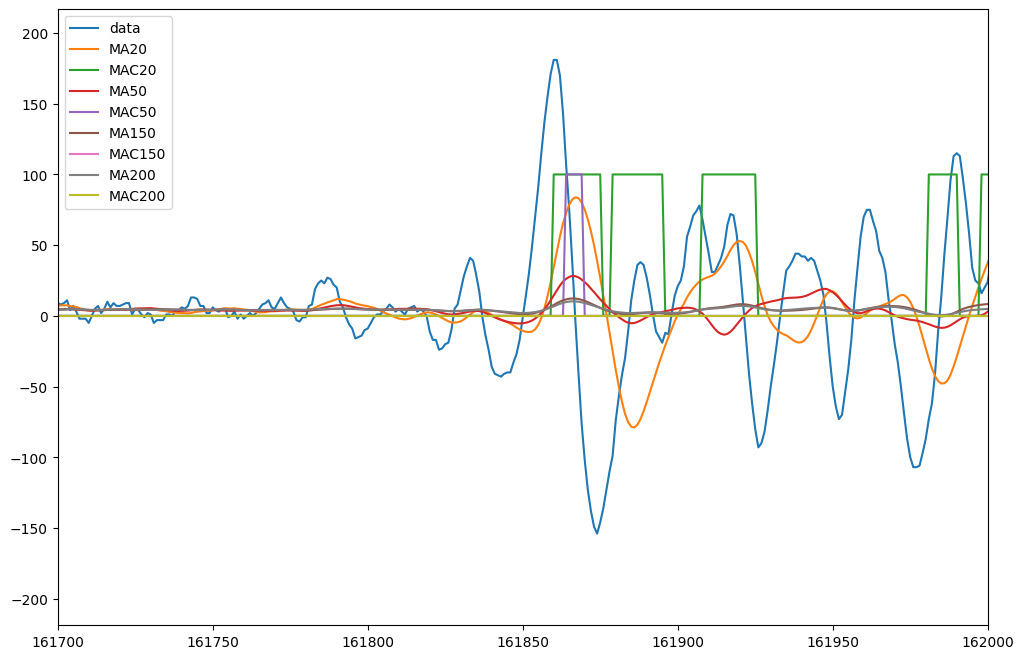

In [55]:
plt.figure(figsize=(12, 8))
n = 0
plt.plot(chunk["acoustic_data"], label="data")

periods = [20, 50, 150, 200]

for period in periods:
    plt.plot(chunk[f'MA{period}'], label=f'MA{period}')
    plt.plot(chunk[f'MAC{period}'], label=f'MAC{period}')
plt.xlim(161700 - n, 162000+n)
#plt.xlim(1000, 10000)
plt.legend()
plt.show()

In [57]:
from sklearn.ensemble import IsolationForest

# Assuming 'chunk' is your DataFrame and 'acoustic_data' is the column
model = IsolationForest(contamination='auto')
chunk['anomaly'] = model.fit_predict(chunk[['acoustic_data']])

# -1 indicates anomaly, 1 indicates normal
earthquakes = chunk[chunk['anomaly'] == -1]


In [33]:
stddev = chunk['acoustic_data'].std()
threshold = 12 * stddev

# Create a new column 'is_earthquake' where 1 indicates a potential earthquake and 0 otherwise
chunk['is_earthquake'] = chunk['acoustic_data'].apply(lambda x: 100 if x > threshold else 0)


In [ ]:
periods = [20, 50, 150, 200]
plt.figure(figsize=(12, 8))
plt.plot(chunk["acoustic_data"], label="data")

plt.axhline(threshold)
plt.plot(chunk['is_earthquake'].iloc[[0, 100000]])
plt.legend()
plt.show()

In [3]:
import pandas as pd
import random

def read_random_consecutive_rows(file_path, N, n, total_rows):
    res = []

    for _ in range(N):
        # Generate a random starting point ensuring we have n rows available
        start_row = random.randint(0, total_rows - n)
        
        # Efficiently skip rows and read n consecutive rows
        chunk = pd.read_csv(file_path, skiprows=range(1, start_row + 1), nrows=n)
        res.append(chunk)

    return res

# Usage example
N = 10  # Number of sets of consecutive rows
n = 100  # Number of consecutive rows per set
total_rows = 6290000  # Input the known total number of rows here
random_rows_df = read_random_consecutive_rows(file_path, N, n, total_rows)
random_rows_df

[    acoustic_data  time_to_failure
 0               7         1.416997
 1               7         1.416997
 2               7         1.416997
 3               9         1.416997
 4               7         1.416997
 ..            ...              ...
 95             10         1.416997
 96             13         1.416997
 97             12         1.416997
 98              1         1.416997
 99              2         1.416997
 
 [100 rows x 2 columns],
     acoustic_data  time_to_failure
 0               4         0.418998
 1               0         0.418998
 2              -1         0.418998
 3               4         0.418998
 4               3         0.418998
 ..            ...              ...
 95              3         0.418998
 96              3         0.418998
 97              9         0.418998
 98              2         0.418998
 99              3         0.418998
 
 [100 rows x 2 columns],
     acoustic_data  time_to_failure
 0               6         1.141398
 1        

In [8]:
df = pd.read_csv("train.csv", nrows=100000)
df2 = pd.read_csv("test/seg_00cc91.csv")

In [9]:
df2.head()

,acoustic_data
0,3
1,3
2,8
3,6
4,6


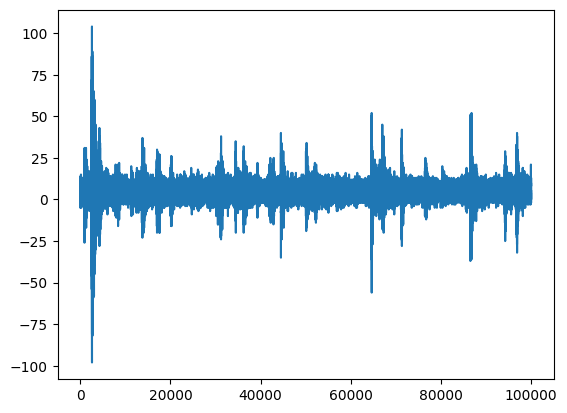

In [7]:
plt.plot(df["acoustic_data"])

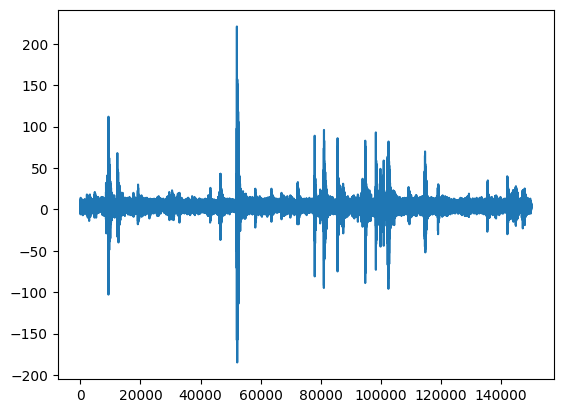

In [10]:
plt.plot(df2["acoustic_data"])